### This notebook is run by: 

`drive_calculate_C3S_GCMs_hindcast_tercile_probabilities.ipynb`   

For a given GCM, initial month, and period, it calculates the tercile climatology, saves the climatology in 

`/media/nicolasf/END19101/ICU/data/CDS/CLIMATOLOGY/{GCM}`

then calculates the probabilities for each year (for the given initial month) and saves them in 

`/media/nicolasf/END19101/ICU/data/CDS/{GCM}/tercile_probs/{varname.upper()}`


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import month_name

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr

# dask 
import dask 
from dask.diagnostics import ProgressBar

In [3]:
import pathlib
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import local functions for the processing of the C3S forecasts 

In [4]:
sys.path.append('../..')

In [5]:
from ICU_Water_Watch import C3S, domains

In [6]:
domain = domains.domains['C3S_download']

In [7]:
domain

[100, 240, -50, 30]

### parameters for papermill 

In [8]:
provider = 'CDS'
varname = 'tprate'
varname_out = 'precip'
period = 'seasonal'
GCM = 'ECMWF'
month = 2
quantile = 'tercile'

In [9]:
# Parameters
GCM = "JMA"
month = 12
period = "monthly"


### list of GCMs 

In [10]:
list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP', 'JMA']

In [11]:
if GCM not in list_GCMs: 
    print(f"{GCM} is not in {', '.join(list_GCMs)}")

### path to the GCMs **hindcast datasets** and **climatologies** 

In [12]:
gcm_path = pathlib.Path(f'/media/nicolasf/END19101/ICU/data/{provider}')

### reads the hindcasts 

In [13]:
GCM

'JMA'

In [14]:
gcm_path.joinpath(f"{GCM}/{varname.upper()}")

PosixPath('/media/nicolasf/END19101/ICU/data/CDS/JMA/TPRATE')

In [15]:
lfiles_hindcast = list(gcm_path.joinpath(f"{GCM}/{varname.upper()}").glob(f"ensemble_seas_forecasts_tprate_from_*_{month:02d}_{GCM}.netcdf"))

### only keep the years 1993 to 2016

In [16]:
lfiles_hindcast.sort()

In [17]:
def get_year(fname): 
    return int(fname.name.split("_")[5])

In [18]:
lfiles_hindcast = [x for x in lfiles_hindcast if get_year(x) <= 2016]

In [19]:
hindcast = xr.open_mfdataset(lfiles_hindcast, preprocess=C3S.preprocess_GCM)

In [20]:
hindcast = domains.extract_domain(hindcast, domain)

In [21]:
hindcast = C3S.convert_rainfall(hindcast, varin='tprate', varout='precip', leadvar='step', timevar='time', dropvar=True)


unit is m s**-1, converting to mm/day

now converting to mm/month, converted precipitation will be held in var = precip


In [22]:
if period == 'seasonal': 

    print("Calculating the seasonal (3 months) accumulations")

    hindcast = hindcast.rolling({'step':3}, min_periods=3, center=False).sum('step') 

    # get rid of the 2 first steps, which by definition contain missing values 

    hindcast = hindcast.sel(step=slice(3, None))

### calculates the climatology 

In [23]:
hindcast.chunks

Frozen({'time': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), 'step': (5,), 'member': (10,), 'lat': (81,), 'lon': (121,)})

In [24]:
hindcast = hindcast.chunk({'time':-1, 'member':-1, 'lat':10, 'lon':10})

In [25]:
instances = len(hindcast.stack(instance=('time','member')).dropna('instance')['instance'])

In [26]:
instances

240

In [27]:
tercile_climatology = hindcast.quantile([0.3333, 0.6666], dim=['time','member'])

In [28]:
with ProgressBar(): 
    tercile_climatology = tercile_climatology.compute()

[                                        ] | 0% Completed |  0.0s

[###########                             ] | 29% Completed |  0.1s

[#######################                 ] | 57% Completed |  0.2s

[#######################                 ] | 59% Completed |  0.3s

[#######################                 ] | 59% Completed |  0.4s

[#######################                 ] | 59% Completed |  0.5s

[#######################                 ] | 59% Completed |  0.6s

[#######################                 ] | 59% Completed |  0.7s

[#######################                 ] | 59% Completed |  0.8s

[########################                ] | 62% Completed |  0.9s

[#########################               ] | 64% Completed |  1.0s

[#########################               ] | 64% Completed |  1.1s

[#########################               ] | 64% Completed |  1.3s

[#########################               ] | 64% Completed |  1.4s

[#########################               ] | 64% Completed |  1.5s

[#########################               ] | 64% Completed |  1.6s

[###########################             ] | 68% Completed |  1.7s

[###########################             ] | 69% Completed |  1.8s

[###########################             ] | 69% Completed |  1.9s

[###########################             ] | 69% Completed |  2.0s

[###########################             ] | 69% Completed |  2.1s

[###########################             ] | 69% Completed |  2.2s

[############################            ] | 70% Completed |  2.3s

[#############################           ] | 73% Completed |  2.4s

[#############################           ] | 74% Completed |  2.5s

[#############################           ] | 74% Completed |  2.6s

[#############################           ] | 74% Completed |  2.7s

[#############################           ] | 74% Completed |  2.8s

[#############################           ] | 74% Completed |  2.9s

[##############################          ] | 76% Completed |  3.0s

[###############################         ] | 78% Completed |  3.1s

[###############################         ] | 78% Completed |  3.2s

[###############################         ] | 79% Completed |  3.3s

[###############################         ] | 79% Completed |  3.5s

[###############################         ] | 79% Completed |  3.6s

[################################        ] | 80% Completed |  3.7s

[################################        ] | 82% Completed |  3.8s

[#################################       ] | 83% Completed |  3.9s

[#################################       ] | 84% Completed |  4.0s

[##################################      ] | 85% Completed |  4.1s

[##################################      ] | 85% Completed |  4.2s

[##################################      ] | 85% Completed |  4.3s

[###################################     ] | 87% Completed |  4.4s

[###################################     ] | 88% Completed |  4.5s

[###################################     ] | 89% Completed |  4.6s

[###################################     ] | 89% Completed |  4.7s

[####################################    ] | 90% Completed |  4.8s

[####################################    ] | 90% Completed |  4.9s

[####################################    ] | 90% Completed |  5.0s

[####################################    ] | 92% Completed |  5.1s

[#####################################   ] | 92% Completed |  5.2s

[#####################################   ] | 94% Completed |  5.3s

[#####################################   ] | 94% Completed |  5.4s

[#####################################   ] | 94% Completed |  5.5s

[#####################################   ] | 94% Completed |  5.6s

[######################################  ] | 96% Completed |  5.7s

[####################################### ] | 98% Completed |  5.8s

[########################################] | 100% Completed |  5.9s

In [29]:
tercile_climatology.attrs['ninstances'] = instances

### save the climatology 

In [30]:
gcm_path

PosixPath('/media/nicolasf/END19101/ICU/data/CDS')

In [31]:
opath_clim = gcm_path.joinpath(f"CLIMATOLOGY/{GCM}/{varname.upper()}")

In [32]:
if not opath_clim.exists(): 
    opath_clim.mkdir(parents=True)

In [33]:
tercile_climatology.to_netcdf(opath_clim.joinpath(f"{GCM}_{period}_{quantile}_climatology_{month:02d}.netcdf"))

### Now derive the categories for the hindcast using the above climatology 

In [34]:
terciles_category = C3S.get_GCM_category_digitize(hindcast, tercile_climatology.squeeze(), varname=varname_out, dim='quantile')

In [35]:
terciles_category

,Array,Chunk
Bytes,89.73 MiB,0.92 MiB
Shape,"(24, 5, 10, 81, 121)","(24, 5, 10, 10, 10)"
Count,1539 Tasks,117 Chunks
Type,int64,numpy.ndarray


### Now calculate the probabilities as the proportion (along the `member` dimension) of members in each categories 

In [36]:
with ProgressBar(): 
    terciles_category_percent = C3S.calculate_quantiles_probabilities(terciles_category, ncategories=3)

[                                        ] | 0% Completed |  0.0s

[######                                  ] | 16% Completed |  0.1s

[#############                           ] | 34% Completed |  0.2s

[######################                  ] | 56% Completed |  0.3s

[######################                  ] | 56% Completed |  0.7s

[######################                  ] | 56% Completed |  1.4s

[######################                  ] | 56% Completed |  1.7s

[######################                  ] | 56% Completed |  2.2s

[######################                  ] | 56% Completed |  3.2s

[######################                  ] | 56% Completed |  5.0s

[######################                  ] | 56% Completed |  5.3s

[######################                  ] | 57% Completed |  5.5s

[######################                  ] | 57% Completed |  6.7s

[#######################                 ] | 57% Completed |  6.9s

[#######################                 ] | 57% Completed |  7.2s

[#######################                 ] | 57% Completed |  7.4s

[#######################                 ] | 58% Completed |  7.6s

[#######################                 ] | 58% Completed |  7.9s

[#######################                 ] | 58% Completed |  8.7s

[#######################                 ] | 58% Completed |  9.6s

[#######################                 ] | 58% Completed |  9.8s

[#######################                 ] | 58% Completed | 10.6s

[#######################                 ] | 58% Completed | 10.8s

[#######################                 ] | 59% Completed | 11.1s

[#######################                 ] | 59% Completed | 11.7s

[#######################                 ] | 59% Completed | 12.0s

[#######################                 ] | 59% Completed | 12.8s

[#######################                 ] | 59% Completed | 13.2s

[#######################                 ] | 59% Completed | 13.6s

[########################                ] | 60% Completed | 13.9s

[########################                ] | 60% Completed | 14.2s

[########################                ] | 60% Completed | 14.5s

[########################                ] | 60% Completed | 14.9s

[########################                ] | 60% Completed | 15.6s

[########################                ] | 61% Completed | 16.2s

[########################                ] | 61% Completed | 16.6s

[########################                ] | 61% Completed | 16.8s

[########################                ] | 61% Completed | 17.2s

[########################                ] | 62% Completed | 17.6s

[########################                ] | 62% Completed | 18.1s

[#########################               ] | 62% Completed | 18.4s

[#########################               ] | 62% Completed | 18.7s

[#########################               ] | 63% Completed | 19.2s

[#########################               ] | 63% Completed | 19.8s

[#########################               ] | 63% Completed | 20.4s

[#########################               ] | 63% Completed | 20.9s

[#########################               ] | 63% Completed | 21.1s

[#########################               ] | 64% Completed | 21.5s

[#########################               ] | 64% Completed | 22.2s

[#########################               ] | 64% Completed | 22.5s

[#########################               ] | 64% Completed | 22.9s

[#########################               ] | 64% Completed | 23.5s

[#########################               ] | 64% Completed | 23.9s

[##########################              ] | 65% Completed | 24.4s

[##########################              ] | 65% Completed | 24.9s

[##########################              ] | 65% Completed | 25.3s

[##########################              ] | 65% Completed | 25.7s

[##########################              ] | 66% Completed | 26.4s

[##########################              ] | 66% Completed | 26.6s

[##########################              ] | 66% Completed | 27.4s

[##########################              ] | 66% Completed | 28.4s

[##########################              ] | 66% Completed | 28.6s

[##########################              ] | 67% Completed | 28.9s

[##########################              ] | 67% Completed | 29.4s

[##########################              ] | 67% Completed | 30.8s

[###########################             ] | 67% Completed | 31.3s

[###########################             ] | 68% Completed | 31.6s

[###########################             ] | 68% Completed | 32.0s

[###########################             ] | 68% Completed | 32.5s

[###########################             ] | 69% Completed | 33.1s

[###########################             ] | 69% Completed | 33.5s

[###########################             ] | 69% Completed | 33.7s

[############################            ] | 70% Completed | 33.9s

[############################            ] | 70% Completed | 35.2s

[############################            ] | 70% Completed | 36.0s

[############################            ] | 71% Completed | 36.4s

[############################            ] | 71% Completed | 36.9s

[############################            ] | 71% Completed | 37.1s

[############################            ] | 71% Completed | 37.8s

[############################            ] | 72% Completed | 38.2s

[############################            ] | 72% Completed | 39.0s

[#############################           ] | 72% Completed | 40.0s

[#############################           ] | 72% Completed | 40.2s

[#############################           ] | 72% Completed | 40.9s

[#############################           ] | 72% Completed | 41.4s

[#############################           ] | 73% Completed | 42.0s

[#############################           ] | 73% Completed | 42.6s

[#############################           ] | 73% Completed | 42.9s

[#############################           ] | 74% Completed | 43.2s

[#############################           ] | 74% Completed | 43.6s

[#############################           ] | 74% Completed | 44.0s

[#############################           ] | 74% Completed | 44.6s

[#############################           ] | 74% Completed | 44.9s

[#############################           ] | 74% Completed | 45.5s

[##############################          ] | 75% Completed | 45.9s

[##############################          ] | 75% Completed | 46.1s

[##############################          ] | 75% Completed | 46.4s

[##############################          ] | 75% Completed | 47.0s

[##############################          ] | 76% Completed | 47.2s

[##############################          ] | 76% Completed | 47.4s

[##############################          ] | 77% Completed | 47.5s

[##############################          ] | 77% Completed | 48.3s

[###############################         ] | 77% Completed | 49.0s

[###############################         ] | 77% Completed | 49.5s

[###############################         ] | 77% Completed | 50.2s

[###############################         ] | 78% Completed | 50.6s

[###############################         ] | 78% Completed | 50.9s

[###############################         ] | 78% Completed | 51.5s

[###############################         ] | 78% Completed | 52.1s

[###############################         ] | 78% Completed | 52.6s

[###############################         ] | 79% Completed | 53.0s

[###############################         ] | 79% Completed | 53.3s

[###############################         ] | 79% Completed | 53.4s

[###############################         ] | 79% Completed | 53.5s

[###############################         ] | 79% Completed | 53.8s

[###############################         ] | 79% Completed | 54.0s

[################################        ] | 80% Completed | 54.3s

[################################        ] | 80% Completed | 54.7s

[################################        ] | 80% Completed | 55.4s

[################################        ] | 80% Completed | 55.5s

[################################        ] | 80% Completed | 55.9s

[################################        ] | 81% Completed | 56.4s

[################################        ] | 81% Completed | 56.6s

[################################        ] | 81% Completed | 56.7s

[################################        ] | 82% Completed | 57.2s

[################################        ] | 82% Completed | 57.4s

[#################################       ] | 82% Completed | 58.2s

[#################################       ] | 83% Completed | 59.5s

[#################################       ] | 83% Completed |  1min  0.7s

[#################################       ] | 83% Completed |  1min  0.9s

[#################################       ] | 83% Completed |  1min  1.2s

[#################################       ] | 83% Completed |  1min  2.0s

[#################################       ] | 84% Completed |  1min  2.6s

[#################################       ] | 84% Completed |  1min  3.3s

[#################################       ] | 84% Completed |  1min  3.7s

[#################################       ] | 84% Completed |  1min  4.3s

[##################################      ] | 85% Completed |  1min  4.6s

[##################################      ] | 85% Completed |  1min  5.1s

[##################################      ] | 85% Completed |  1min  5.7s

[##################################      ] | 85% Completed |  1min  5.9s

[##################################      ] | 85% Completed |  1min  6.4s

[##################################      ] | 86% Completed |  1min  6.8s

[##################################      ] | 86% Completed |  1min  7.0s

[##################################      ] | 87% Completed |  1min  7.5s

[###################################     ] | 87% Completed |  1min  7.8s

[###################################     ] | 88% Completed |  1min  8.6s

[###################################     ] | 88% Completed |  1min  9.2s

[###################################     ] | 88% Completed |  1min  9.7s

[###################################     ] | 88% Completed |  1min 10.3s

[###################################     ] | 88% Completed |  1min 10.5s

[###################################     ] | 89% Completed |  1min 10.7s

[###################################     ] | 89% Completed |  1min 11.7s

[###################################     ] | 89% Completed |  1min 12.3s

[####################################    ] | 90% Completed |  1min 12.6s

[####################################    ] | 90% Completed |  1min 13.6s

[####################################    ] | 90% Completed |  1min 14.0s

[####################################    ] | 90% Completed |  1min 14.5s

[####################################    ] | 90% Completed |  1min 15.2s

[####################################    ] | 90% Completed |  1min 16.0s

[####################################    ] | 90% Completed |  1min 16.6s

[####################################    ] | 91% Completed |  1min 17.9s

[####################################    ] | 91% Completed |  1min 19.9s

[####################################    ] | 91% Completed |  1min 20.3s

[####################################    ] | 92% Completed |  1min 20.4s

[####################################    ] | 92% Completed |  1min 20.6s

[#####################################   ] | 93% Completed |  1min 20.7s

[#####################################   ] | 93% Completed |  1min 21.0s

[#####################################   ] | 93% Completed |  1min 21.2s

[#####################################   ] | 93% Completed |  1min 21.5s

[#####################################   ] | 94% Completed |  1min 21.7s

[#####################################   ] | 94% Completed |  1min 22.5s

[######################################  ] | 95% Completed |  1min 23.3s

[######################################  ] | 95% Completed |  1min 23.9s

[######################################  ] | 95% Completed |  1min 24.7s

[######################################  ] | 95% Completed |  1min 25.4s

[######################################  ] | 95% Completed |  1min 26.0s

[######################################  ] | 95% Completed |  1min 27.0s

[######################################  ] | 96% Completed |  1min 28.0s

[######################################  ] | 96% Completed |  1min 29.2s

[######################################  ] | 96% Completed |  1min 29.7s

[######################################  ] | 96% Completed |  1min 30.4s

[######################################  ] | 97% Completed |  1min 30.8s

[######################################  ] | 97% Completed |  1min 31.1s

[####################################### ] | 98% Completed |  1min 31.6s

[####################################### ] | 98% Completed |  1min 31.8s

[####################################### ] | 98% Completed |  1min 32.7s

[####################################### ] | 98% Completed |  1min 33.0s

[####################################### ] | 98% Completed |  1min 33.4s

[####################################### ] | 98% Completed |  1min 34.0s

[####################################### ] | 98% Completed |  1min 34.3s

[####################################### ] | 98% Completed |  1min 35.0s

[####################################### ] | 99% Completed |  1min 35.4s

[####################################### ] | 99% Completed |  1min 35.8s

[####################################### ] | 99% Completed |  1min 35.9s

[####################################### ] | 99% Completed |  1min 36.1s

[####################################### ] | 99% Completed |  1min 36.2s

[########################################] | 100% Completed |  1min 36.3s

[                                        ] | 0% Completed |  0.0s

[######                                  ] | 17% Completed |  0.1s

[###############                         ] | 38% Completed |  0.2s

[#####################                   ] | 54% Completed |  0.3s

[#####################                   ] | 54% Completed |  0.6s

[#####################                   ] | 54% Completed |  0.8s

[#####################                   ] | 54% Completed |  1.1s

[######################                  ] | 55% Completed |  2.4s

[######################                  ] | 55% Completed |  3.3s

[######################                  ] | 55% Completed |  3.7s

[######################                  ] | 55% Completed |  4.2s

[######################                  ] | 55% Completed |  5.2s

[######################                  ] | 55% Completed |  6.1s

[######################                  ] | 55% Completed |  6.4s

[######################                  ] | 55% Completed |  6.9s

[######################                  ] | 55% Completed |  7.3s

[######################                  ] | 55% Completed |  7.8s

[######################                  ] | 55% Completed |  8.2s

[######################                  ] | 55% Completed |  8.6s

[######################                  ] | 55% Completed |  9.2s

[######################                  ] | 55% Completed |  9.4s

[######################                  ] | 55% Completed |  9.7s

[######################                  ] | 56% Completed |  9.9s

[######################                  ] | 56% Completed | 10.2s

[######################                  ] | 56% Completed | 10.8s

[######################                  ] | 56% Completed | 11.0s

[######################                  ] | 56% Completed | 11.8s

[######################                  ] | 56% Completed | 12.4s

[######################                  ] | 57% Completed | 13.0s

[#######################                 ] | 57% Completed | 13.5s

[#######################                 ] | 57% Completed | 13.9s

[#######################                 ] | 58% Completed | 14.1s

[#######################                 ] | 58% Completed | 14.5s

[#######################                 ] | 58% Completed | 15.0s

[#######################                 ] | 58% Completed | 15.8s

[#######################                 ] | 59% Completed | 16.3s

[#######################                 ] | 59% Completed | 16.8s

[#######################                 ] | 59% Completed | 17.1s

[#######################                 ] | 59% Completed | 17.3s

[#######################                 ] | 59% Completed | 17.8s

[#######################                 ] | 59% Completed | 18.4s

[########################                ] | 60% Completed | 19.0s

[########################                ] | 60% Completed | 19.2s

[########################                ] | 60% Completed | 19.4s

[########################                ] | 60% Completed | 19.6s

[########################                ] | 61% Completed | 19.9s

[########################                ] | 61% Completed | 20.6s

[########################                ] | 61% Completed | 21.3s

[########################                ] | 61% Completed | 21.9s

[########################                ] | 62% Completed | 23.2s

[########################                ] | 62% Completed | 24.0s

[#########################               ] | 62% Completed | 24.7s

[#########################               ] | 62% Completed | 25.0s

[#########################               ] | 63% Completed | 25.7s

[#########################               ] | 63% Completed | 26.0s

[#########################               ] | 64% Completed | 26.2s

[#########################               ] | 64% Completed | 26.4s

[#########################               ] | 64% Completed | 26.7s

[#########################               ] | 64% Completed | 26.8s

[#########################               ] | 64% Completed | 27.1s

[##########################              ] | 65% Completed | 27.3s

[##########################              ] | 65% Completed | 27.4s

[##########################              ] | 66% Completed | 28.0s

[##########################              ] | 66% Completed | 28.3s

[##########################              ] | 66% Completed | 29.0s

[##########################              ] | 66% Completed | 29.7s

[##########################              ] | 66% Completed | 30.6s

[##########################              ] | 66% Completed | 30.9s

[##########################              ] | 67% Completed | 31.5s

[##########################              ] | 67% Completed | 31.9s

[###########################             ] | 67% Completed | 32.4s

[###########################             ] | 67% Completed | 32.7s

[###########################             ] | 68% Completed | 33.2s

[###########################             ] | 68% Completed | 34.7s

[###########################             ] | 68% Completed | 35.2s

[###########################             ] | 68% Completed | 36.0s

[###########################             ] | 68% Completed | 37.6s

[###########################             ] | 69% Completed | 37.7s

[###########################             ] | 69% Completed | 38.1s

[############################            ] | 70% Completed | 39.0s

[############################            ] | 71% Completed | 39.2s

[############################            ] | 71% Completed | 39.4s

[############################            ] | 71% Completed | 41.4s

[############################            ] | 72% Completed | 41.8s

[############################            ] | 72% Completed | 42.0s

[############################            ] | 72% Completed | 42.7s

[#############################           ] | 72% Completed | 43.0s

[#############################           ] | 73% Completed | 44.1s

[#############################           ] | 73% Completed | 44.7s

[#############################           ] | 73% Completed | 45.4s

[#############################           ] | 73% Completed | 45.6s

[#############################           ] | 73% Completed | 46.3s

[#############################           ] | 74% Completed | 46.7s

[#############################           ] | 74% Completed | 46.8s

[##############################          ] | 75% Completed | 47.1s

[##############################          ] | 75% Completed | 47.4s

[##############################          ] | 75% Completed | 47.8s

[##############################          ] | 75% Completed | 48.3s

[##############################          ] | 76% Completed | 48.5s

[##############################          ] | 76% Completed | 49.2s

[##############################          ] | 76% Completed | 49.7s

[##############################          ] | 76% Completed | 50.6s

[##############################          ] | 77% Completed | 51.0s

[###############################         ] | 77% Completed | 51.6s

[###############################         ] | 77% Completed | 52.0s

[###############################         ] | 78% Completed | 52.2s

[###############################         ] | 78% Completed | 52.5s

[###############################         ] | 78% Completed | 53.3s

[###############################         ] | 78% Completed | 53.7s

[###############################         ] | 78% Completed | 53.8s

[###############################         ] | 78% Completed | 54.2s

[###############################         ] | 78% Completed | 54.6s

[###############################         ] | 78% Completed | 55.0s

[###############################         ] | 78% Completed | 55.6s

[###############################         ] | 79% Completed | 56.5s

[###############################         ] | 79% Completed | 56.7s

[###############################         ] | 79% Completed | 57.0s

[################################        ] | 80% Completed | 57.5s

[################################        ] | 80% Completed | 57.6s

[################################        ] | 80% Completed | 58.0s

[################################        ] | 81% Completed | 58.7s

[################################        ] | 81% Completed | 59.5s

[################################        ] | 81% Completed | 60.0s

[################################        ] | 81% Completed |  1min  0.5s

[################################        ] | 82% Completed |  1min  1.4s

[################################        ] | 82% Completed |  1min  1.7s

[#################################       ] | 82% Completed |  1min  2.1s

[#################################       ] | 83% Completed |  1min  2.6s

[#################################       ] | 83% Completed |  1min  2.7s

[#################################       ] | 83% Completed |  1min  3.7s

[#################################       ] | 83% Completed |  1min  4.5s

[#################################       ] | 83% Completed |  1min  4.7s

[#################################       ] | 83% Completed |  1min  5.1s

[#################################       ] | 83% Completed |  1min  5.4s

[#################################       ] | 83% Completed |  1min  5.7s

[#################################       ] | 84% Completed |  1min  6.2s

[#################################       ] | 84% Completed |  1min  6.3s

[#################################       ] | 84% Completed |  1min  6.7s

[#################################       ] | 84% Completed |  1min  7.3s

[#################################       ] | 84% Completed |  1min  7.7s

[##################################      ] | 85% Completed |  1min  8.0s

[##################################      ] | 85% Completed |  1min  8.1s

[##################################      ] | 86% Completed |  1min  8.3s

[##################################      ] | 86% Completed |  1min  8.6s

[##################################      ] | 86% Completed |  1min  8.9s

[##################################      ] | 87% Completed |  1min  9.5s

[###################################     ] | 87% Completed |  1min 10.0s

[###################################     ] | 87% Completed |  1min 10.9s

[###################################     ] | 87% Completed |  1min 11.3s

[###################################     ] | 88% Completed |  1min 11.9s

[###################################     ] | 88% Completed |  1min 12.3s

[###################################     ] | 88% Completed |  1min 12.4s

[###################################     ] | 88% Completed |  1min 12.8s

[###################################     ] | 88% Completed |  1min 13.2s

[###################################     ] | 88% Completed |  1min 13.6s

[###################################     ] | 89% Completed |  1min 14.2s

[###################################     ] | 89% Completed |  1min 14.7s

[###################################     ] | 89% Completed |  1min 15.4s

[###################################     ] | 89% Completed |  1min 17.2s

[###################################     ] | 89% Completed |  1min 18.1s

[###################################     ] | 89% Completed |  1min 18.6s

[###################################     ] | 89% Completed |  1min 19.0s

[###################################     ] | 89% Completed |  1min 19.3s

[####################################    ] | 90% Completed |  1min 19.9s

[####################################    ] | 90% Completed |  1min 20.2s

[####################################    ] | 90% Completed |  1min 20.5s

[####################################    ] | 90% Completed |  1min 20.7s

[####################################    ] | 91% Completed |  1min 21.2s

[####################################    ] | 91% Completed |  1min 21.4s

[####################################    ] | 92% Completed |  1min 21.6s

[####################################    ] | 92% Completed |  1min 21.9s

[#####################################   ] | 92% Completed |  1min 22.1s

[#####################################   ] | 92% Completed |  1min 22.4s

[#####################################   ] | 92% Completed |  1min 22.6s

[#####################################   ] | 93% Completed |  1min 23.1s

[#####################################   ] | 93% Completed |  1min 23.4s

[#####################################   ] | 93% Completed |  1min 23.8s

[#####################################   ] | 93% Completed |  1min 24.2s

[#####################################   ] | 94% Completed |  1min 25.1s

[#####################################   ] | 94% Completed |  1min 25.3s

[#####################################   ] | 94% Completed |  1min 26.1s

[#####################################   ] | 94% Completed |  1min 26.8s

[#####################################   ] | 94% Completed |  1min 27.2s

[######################################  ] | 95% Completed |  1min 27.9s

[######################################  ] | 95% Completed |  1min 28.4s

[######################################  ] | 96% Completed |  1min 28.6s

[######################################  ] | 96% Completed |  1min 28.7s

[######################################  ] | 97% Completed |  1min 29.0s

[######################################  ] | 97% Completed |  1min 29.7s

[####################################### ] | 97% Completed |  1min 30.1s

[####################################### ] | 97% Completed |  1min 30.5s

[####################################### ] | 97% Completed |  1min 31.0s

[####################################### ] | 98% Completed |  1min 32.1s

[####################################### ] | 98% Completed |  1min 33.1s

[####################################### ] | 98% Completed |  1min 33.7s

[####################################### ] | 98% Completed |  1min 34.1s

[####################################### ] | 98% Completed |  1min 34.5s

[####################################### ] | 98% Completed |  1min 35.0s

[####################################### ] | 98% Completed |  1min 35.6s

[####################################### ] | 98% Completed |  1min 36.3s

[####################################### ] | 98% Completed |  1min 36.5s

[####################################### ] | 98% Completed |  1min 37.0s

[####################################### ] | 98% Completed |  1min 37.4s

[####################################### ] | 99% Completed |  1min 37.7s

[####################################### ] | 99% Completed |  1min 38.0s

[####################################### ] | 99% Completed |  1min 38.2s

[####################################### ] | 99% Completed |  1min 38.3s

[########################################] | 100% Completed |  1min 38.4s

[                                        ] | 0% Completed |  0.0s

[#####                                   ] | 13% Completed |  0.1s

[###########                             ] | 28% Completed |  0.2s

[######################                  ] | 55% Completed |  0.3s

[######################                  ] | 55% Completed |  0.4s

[######################                  ] | 55% Completed |  0.7s

[######################                  ] | 56% Completed |  1.0s

[######################                  ] | 56% Completed |  1.3s

[######################                  ] | 56% Completed |  2.4s

[######################                  ] | 56% Completed |  2.6s

[######################                  ] | 56% Completed |  3.1s

[######################                  ] | 56% Completed |  3.3s

[######################                  ] | 56% Completed |  3.8s

[######################                  ] | 56% Completed |  4.9s

[######################                  ] | 56% Completed |  6.2s

[######################                  ] | 56% Completed |  6.8s

[######################                  ] | 56% Completed |  7.0s

[######################                  ] | 56% Completed |  7.7s

[######################                  ] | 56% Completed |  8.2s

[######################                  ] | 56% Completed |  8.5s

[######################                  ] | 56% Completed |  9.4s

[######################                  ] | 56% Completed |  9.8s

[######################                  ] | 56% Completed | 10.2s

[######################                  ] | 57% Completed | 11.0s

[######################                  ] | 57% Completed | 11.4s

[######################                  ] | 57% Completed | 11.9s

[#######################                 ] | 57% Completed | 12.1s

[#######################                 ] | 57% Completed | 12.5s

[#######################                 ] | 58% Completed | 13.3s

[#######################                 ] | 58% Completed | 13.4s

[#######################                 ] | 58% Completed | 13.6s

[#######################                 ] | 59% Completed | 14.0s

[#######################                 ] | 59% Completed | 14.2s

[#######################                 ] | 59% Completed | 14.7s

[########################                ] | 60% Completed | 15.1s

[########################                ] | 60% Completed | 15.5s

[########################                ] | 60% Completed | 16.0s

[########################                ] | 61% Completed | 16.5s

[########################                ] | 61% Completed | 17.2s

[########################                ] | 61% Completed | 18.3s

[########################                ] | 61% Completed | 18.5s

[########################                ] | 61% Completed | 19.1s

[########################                ] | 61% Completed | 19.4s

[########################                ] | 62% Completed | 20.2s

[########################                ] | 62% Completed | 20.4s

[#########################               ] | 62% Completed | 20.7s

[#########################               ] | 62% Completed | 21.0s

[#########################               ] | 62% Completed | 21.6s

[#########################               ] | 62% Completed | 21.9s

[#########################               ] | 62% Completed | 22.2s

[#########################               ] | 62% Completed | 22.4s

[#########################               ] | 62% Completed | 23.3s

[#########################               ] | 63% Completed | 23.7s

[#########################               ] | 63% Completed | 24.0s

[#########################               ] | 63% Completed | 24.4s

[#########################               ] | 63% Completed | 24.8s

[#########################               ] | 63% Completed | 25.4s

[#########################               ] | 64% Completed | 25.9s

[#########################               ] | 64% Completed | 26.7s

[#########################               ] | 64% Completed | 27.2s

[#########################               ] | 64% Completed | 27.4s

[#########################               ] | 64% Completed | 27.6s

[##########################              ] | 65% Completed | 27.9s

[##########################              ] | 65% Completed | 28.0s

[##########################              ] | 66% Completed | 28.2s

[##########################              ] | 67% Completed | 28.3s

[##########################              ] | 67% Completed | 28.6s

[##########################              ] | 67% Completed | 29.3s

[###########################             ] | 67% Completed | 29.9s

[###########################             ] | 67% Completed | 30.5s

[###########################             ] | 67% Completed | 31.4s

[###########################             ] | 67% Completed | 31.7s

[###########################             ] | 68% Completed | 32.2s

[###########################             ] | 68% Completed | 32.6s

[###########################             ] | 68% Completed | 32.8s

[###########################             ] | 68% Completed | 33.6s

[###########################             ] | 69% Completed | 34.6s

[###########################             ] | 69% Completed | 35.0s

[###########################             ] | 69% Completed | 35.7s

[###########################             ] | 69% Completed | 36.2s

[############################            ] | 70% Completed | 36.6s

[############################            ] | 70% Completed | 37.0s

[############################            ] | 70% Completed | 37.8s

[############################            ] | 70% Completed | 38.2s

[############################            ] | 71% Completed | 39.0s

[############################            ] | 71% Completed | 39.2s

[############################            ] | 71% Completed | 40.4s

[############################            ] | 71% Completed | 40.7s

[############################            ] | 71% Completed | 42.2s

[############################            ] | 71% Completed | 42.8s

[############################            ] | 72% Completed | 43.1s

[############################            ] | 72% Completed | 43.4s

[############################            ] | 72% Completed | 43.5s

[#############################           ] | 73% Completed | 44.1s

[#############################           ] | 73% Completed | 44.3s

[#############################           ] | 73% Completed | 44.5s

[#############################           ] | 73% Completed | 45.0s

[#############################           ] | 74% Completed | 45.2s

[#############################           ] | 74% Completed | 45.4s

[#############################           ] | 74% Completed | 46.2s

[#############################           ] | 74% Completed | 46.5s

[#############################           ] | 74% Completed | 47.5s

[##############################          ] | 75% Completed | 47.7s

[##############################          ] | 75% Completed | 48.2s

[##############################          ] | 75% Completed | 48.5s

[##############################          ] | 76% Completed | 48.8s

[##############################          ] | 76% Completed | 48.9s

[##############################          ] | 76% Completed | 49.1s

[##############################          ] | 76% Completed | 49.6s

[##############################          ] | 76% Completed | 49.8s

[##############################          ] | 76% Completed | 50.4s

[##############################          ] | 77% Completed | 50.7s

[###############################         ] | 77% Completed | 51.0s

[###############################         ] | 77% Completed | 51.8s

[###############################         ] | 77% Completed | 52.8s

[###############################         ] | 78% Completed | 53.1s

[###############################         ] | 78% Completed | 53.3s

[###############################         ] | 78% Completed | 53.8s

[###############################         ] | 78% Completed | 53.9s

[###############################         ] | 78% Completed | 54.1s

[###############################         ] | 79% Completed | 55.0s

[###############################         ] | 79% Completed | 55.9s

[###############################         ] | 79% Completed | 56.1s

[###############################         ] | 79% Completed | 56.6s

[###############################         ] | 79% Completed | 56.7s

[################################        ] | 80% Completed | 57.3s

[################################        ] | 80% Completed | 58.0s

[################################        ] | 80% Completed | 58.2s

[################################        ] | 81% Completed | 58.3s

[################################        ] | 81% Completed | 58.7s

[################################        ] | 81% Completed | 59.3s

[################################        ] | 81% Completed | 59.7s

[################################        ] | 81% Completed |  1min  0.5s

[################################        ] | 82% Completed |  1min  0.9s

[################################        ] | 82% Completed |  1min  1.2s

[################################        ] | 82% Completed |  1min  1.5s

[#################################       ] | 82% Completed |  1min  2.7s

[#################################       ] | 83% Completed |  1min  3.4s

[#################################       ] | 83% Completed |  1min  3.6s

[#################################       ] | 83% Completed |  1min  4.0s

[#################################       ] | 83% Completed |  1min  4.4s

[#################################       ] | 83% Completed |  1min  4.7s

[#################################       ] | 84% Completed |  1min  5.1s

[#################################       ] | 84% Completed |  1min  5.8s

[#################################       ] | 84% Completed |  1min  6.7s

[##################################      ] | 85% Completed |  1min  7.1s

[##################################      ] | 85% Completed |  1min  7.4s

[##################################      ] | 85% Completed |  1min  8.0s

[##################################      ] | 85% Completed |  1min  8.4s

[##################################      ] | 85% Completed |  1min  8.6s

[##################################      ] | 86% Completed |  1min  9.0s

[##################################      ] | 86% Completed |  1min  9.5s

[##################################      ] | 86% Completed |  1min  9.8s

[##################################      ] | 86% Completed |  1min 10.7s

[##################################      ] | 87% Completed |  1min 10.9s

[##################################      ] | 87% Completed |  1min 11.8s

[###################################     ] | 87% Completed |  1min 13.1s

[###################################     ] | 88% Completed |  1min 13.9s

[###################################     ] | 88% Completed |  1min 14.4s

[###################################     ] | 88% Completed |  1min 14.9s

[###################################     ] | 88% Completed |  1min 15.8s

[###################################     ] | 88% Completed |  1min 16.2s

[###################################     ] | 88% Completed |  1min 16.4s

[###################################     ] | 89% Completed |  1min 16.7s

[###################################     ] | 89% Completed |  1min 16.9s

[###################################     ] | 89% Completed |  1min 17.0s

[###################################     ] | 89% Completed |  1min 17.2s

[###################################     ] | 89% Completed |  1min 17.7s

[####################################    ] | 90% Completed |  1min 17.9s

[####################################    ] | 90% Completed |  1min 18.2s

[####################################    ] | 91% Completed |  1min 18.3s

[####################################    ] | 91% Completed |  1min 18.8s

[####################################    ] | 91% Completed |  1min 19.2s

[####################################    ] | 91% Completed |  1min 19.9s

[####################################    ] | 91% Completed |  1min 20.2s

[####################################    ] | 91% Completed |  1min 21.2s

[####################################    ] | 92% Completed |  1min 21.5s

[####################################    ] | 92% Completed |  1min 21.6s

[####################################    ] | 92% Completed |  1min 22.2s

[#####################################   ] | 92% Completed |  1min 22.4s

[#####################################   ] | 93% Completed |  1min 22.8s

[#####################################   ] | 93% Completed |  1min 23.5s

[#####################################   ] | 93% Completed |  1min 24.1s

[#####################################   ] | 93% Completed |  1min 25.3s

[#####################################   ] | 93% Completed |  1min 26.0s

[#####################################   ] | 94% Completed |  1min 26.5s

[#####################################   ] | 94% Completed |  1min 26.6s

[######################################  ] | 95% Completed |  1min 27.0s

[######################################  ] | 95% Completed |  1min 27.5s

[######################################  ] | 95% Completed |  1min 28.2s

[######################################  ] | 95% Completed |  1min 28.5s

[######################################  ] | 95% Completed |  1min 29.0s

[######################################  ] | 96% Completed |  1min 29.4s

[######################################  ] | 96% Completed |  1min 30.1s

[######################################  ] | 96% Completed |  1min 31.1s

[######################################  ] | 96% Completed |  1min 31.3s

[######################################  ] | 96% Completed |  1min 31.7s

[######################################  ] | 96% Completed |  1min 32.9s

[######################################  ] | 96% Completed |  1min 33.2s

[######################################  ] | 97% Completed |  1min 34.0s

[####################################### ] | 97% Completed |  1min 34.1s

[####################################### ] | 97% Completed |  1min 34.3s

[####################################### ] | 98% Completed |  1min 34.5s

[####################################### ] | 98% Completed |  1min 34.6s

[####################################### ] | 99% Completed |  1min 35.3s

[####################################### ] | 99% Completed |  1min 36.0s

[####################################### ] | 99% Completed |  1min 36.9s

[####################################### ] | 99% Completed |  1min 37.2s

[####################################### ] | 99% Completed |  1min 37.5s

[####################################### ] | 99% Completed |  1min 37.7s

[####################################### ] | 99% Completed |  1min 37.9s

[########################################] | 100% Completed |  1min 38.0s

[                                        ] | 0% Completed |  0.0s

[######                                  ] | 16% Completed |  0.1s

[##############                          ] | 35% Completed |  0.2s

[#####################                   ] | 53% Completed |  0.3s

[#####################                   ] | 53% Completed |  1.4s

[#####################                   ] | 54% Completed |  2.6s

[#####################                   ] | 54% Completed |  2.9s

[#####################                   ] | 54% Completed |  3.2s

[#####################                   ] | 54% Completed |  4.3s

[#####################                   ] | 54% Completed |  5.2s

[######################                  ] | 55% Completed |  5.7s

[######################                  ] | 55% Completed |  6.0s

[######################                  ] | 55% Completed |  6.4s

[######################                  ] | 55% Completed |  7.1s

[######################                  ] | 55% Completed |  9.2s

[######################                  ] | 55% Completed |  9.4s

[######################                  ] | 55% Completed |  9.7s

[######################                  ] | 56% Completed | 10.0s

[######################                  ] | 56% Completed | 10.4s

[######################                  ] | 56% Completed | 10.9s

[######################                  ] | 56% Completed | 11.2s

[######################                  ] | 57% Completed | 11.9s

[######################                  ] | 57% Completed | 12.2s

[######################                  ] | 57% Completed | 13.1s

[######################                  ] | 57% Completed | 13.2s

[#######################                 ] | 58% Completed | 13.7s

[#######################                 ] | 58% Completed | 14.9s

[#######################                 ] | 58% Completed | 15.2s

[#######################                 ] | 58% Completed | 15.5s

[#######################                 ] | 58% Completed | 15.8s

[#######################                 ] | 58% Completed | 16.8s

[#######################                 ] | 58% Completed | 17.1s

[#######################                 ] | 59% Completed | 17.8s

[#######################                 ] | 59% Completed | 18.2s

[#######################                 ] | 59% Completed | 18.5s

[#######################                 ] | 59% Completed | 18.9s

[#######################                 ] | 59% Completed | 19.0s

[########################                ] | 60% Completed | 20.0s

[########################                ] | 60% Completed | 20.9s

[########################                ] | 60% Completed | 22.2s

[########################                ] | 60% Completed | 22.3s

[########################                ] | 61% Completed | 22.5s

[########################                ] | 61% Completed | 22.7s

[########################                ] | 61% Completed | 23.1s

[########################                ] | 62% Completed | 23.7s

[########################                ] | 62% Completed | 24.2s

[#########################               ] | 62% Completed | 24.7s

[#########################               ] | 63% Completed | 25.3s

[#########################               ] | 63% Completed | 25.7s

[#########################               ] | 64% Completed | 26.9s

[#########################               ] | 64% Completed | 27.2s

[#########################               ] | 64% Completed | 27.9s

[##########################              ] | 65% Completed | 29.7s

[##########################              ] | 65% Completed | 30.1s

[##########################              ] | 65% Completed | 30.8s

[##########################              ] | 65% Completed | 31.0s

[##########################              ] | 65% Completed | 31.2s

[##########################              ] | 66% Completed | 31.5s

[##########################              ] | 67% Completed | 32.1s

[##########################              ] | 67% Completed | 32.4s

[##########################              ] | 67% Completed | 33.3s

[###########################             ] | 67% Completed | 34.4s

[###########################             ] | 67% Completed | 34.8s

[###########################             ] | 68% Completed | 35.5s

[###########################             ] | 68% Completed | 35.8s

[###########################             ] | 68% Completed | 36.4s

[###########################             ] | 69% Completed | 36.9s

[###########################             ] | 69% Completed | 37.7s

[###########################             ] | 69% Completed | 38.5s

[###########################             ] | 69% Completed | 39.0s

[###########################             ] | 69% Completed | 39.7s

[###########################             ] | 69% Completed | 40.2s

[############################            ] | 70% Completed | 40.8s

[############################            ] | 70% Completed | 41.1s

[############################            ] | 70% Completed | 41.8s

[############################            ] | 70% Completed | 42.4s

[############################            ] | 71% Completed | 42.7s

[############################            ] | 71% Completed | 43.4s

[############################            ] | 71% Completed | 43.6s

[############################            ] | 71% Completed | 43.7s

[############################            ] | 72% Completed | 44.1s

[############################            ] | 72% Completed | 44.4s

[#############################           ] | 72% Completed | 44.7s

[#############################           ] | 73% Completed | 45.2s

[#############################           ] | 73% Completed | 46.0s

[#############################           ] | 74% Completed | 46.6s

[#############################           ] | 74% Completed | 46.9s

[#############################           ] | 74% Completed | 47.4s

[#############################           ] | 74% Completed | 47.7s

[#############################           ] | 74% Completed | 48.6s

[##############################          ] | 75% Completed | 49.5s

[##############################          ] | 75% Completed | 50.2s

[##############################          ] | 75% Completed | 50.6s

[##############################          ] | 76% Completed | 50.9s

[##############################          ] | 76% Completed | 51.2s

[##############################          ] | 76% Completed | 52.0s

[##############################          ] | 77% Completed | 52.2s

[##############################          ] | 77% Completed | 53.4s

[##############################          ] | 77% Completed | 53.7s

[###############################         ] | 77% Completed | 54.3s

[###############################         ] | 78% Completed | 54.5s

[###############################         ] | 78% Completed | 55.8s

[###############################         ] | 78% Completed | 56.1s

[###############################         ] | 78% Completed | 56.8s

[###############################         ] | 79% Completed | 57.3s

[###############################         ] | 79% Completed | 57.6s

[################################        ] | 80% Completed | 57.8s

[################################        ] | 80% Completed | 58.1s

[################################        ] | 80% Completed | 58.3s

[################################        ] | 81% Completed | 58.8s

[################################        ] | 81% Completed | 59.8s

[################################        ] | 81% Completed |  1min  0.5s

[################################        ] | 81% Completed |  1min  1.1s

[################################        ] | 81% Completed |  1min  1.7s

[################################        ] | 81% Completed |  1min  2.4s

[################################        ] | 82% Completed |  1min  3.0s

[################################        ] | 82% Completed |  1min  3.7s

[#################################       ] | 82% Completed |  1min  4.0s

[#################################       ] | 82% Completed |  1min  4.9s

[#################################       ] | 83% Completed |  1min  5.1s

[#################################       ] | 83% Completed |  1min  5.6s

[#################################       ] | 83% Completed |  1min  6.1s

[#################################       ] | 83% Completed |  1min  7.0s

[#################################       ] | 83% Completed |  1min  7.2s

[#################################       ] | 84% Completed |  1min  7.4s

[#################################       ] | 84% Completed |  1min  7.6s

[##################################      ] | 85% Completed |  1min  7.9s

[##################################      ] | 85% Completed |  1min  8.1s

[##################################      ] | 85% Completed |  1min  8.4s

[##################################      ] | 85% Completed |  1min  8.8s

[##################################      ] | 85% Completed |  1min  9.3s

[##################################      ] | 86% Completed |  1min 10.3s

[##################################      ] | 86% Completed |  1min 10.7s

[##################################      ] | 86% Completed |  1min 11.2s

[##################################      ] | 86% Completed |  1min 11.8s

[##################################      ] | 86% Completed |  1min 12.5s

[##################################      ] | 87% Completed |  1min 12.9s

[###################################     ] | 87% Completed |  1min 13.8s

[###################################     ] | 87% Completed |  1min 14.4s

[###################################     ] | 87% Completed |  1min 14.9s

[###################################     ] | 87% Completed |  1min 15.8s

[###################################     ] | 88% Completed |  1min 16.2s

[###################################     ] | 88% Completed |  1min 16.4s

[###################################     ] | 88% Completed |  1min 16.8s

[###################################     ] | 88% Completed |  1min 17.2s

[###################################     ] | 89% Completed |  1min 17.6s

[###################################     ] | 89% Completed |  1min 17.8s

[###################################     ] | 89% Completed |  1min 18.2s

[###################################     ] | 89% Completed |  1min 18.7s

[####################################    ] | 90% Completed |  1min 19.0s

[####################################    ] | 90% Completed |  1min 19.3s

[####################################    ] | 90% Completed |  1min 19.7s

[####################################    ] | 91% Completed |  1min 20.3s

[####################################    ] | 91% Completed |  1min 20.9s

[####################################    ] | 91% Completed |  1min 21.4s

[####################################    ] | 91% Completed |  1min 21.8s

[####################################    ] | 91% Completed |  1min 22.0s

[####################################    ] | 91% Completed |  1min 22.5s

[####################################    ] | 92% Completed |  1min 23.4s

[#####################################   ] | 93% Completed |  1min 23.9s

[#####################################   ] | 93% Completed |  1min 24.0s

[#####################################   ] | 94% Completed |  1min 24.2s

[#####################################   ] | 94% Completed |  1min 24.3s

[######################################  ] | 95% Completed |  1min 24.5s

[######################################  ] | 96% Completed |  1min 25.4s

[######################################  ] | 96% Completed |  1min 25.8s

[######################################  ] | 96% Completed |  1min 26.2s

[######################################  ] | 96% Completed |  1min 27.2s

[######################################  ] | 96% Completed |  1min 27.6s

[######################################  ] | 97% Completed |  1min 27.8s

[######################################  ] | 97% Completed |  1min 29.1s

[######################################  ] | 97% Completed |  1min 29.6s

[######################################  ] | 97% Completed |  1min 30.1s

[####################################### ] | 97% Completed |  1min 30.9s

[####################################### ] | 98% Completed |  1min 31.8s

[####################################### ] | 98% Completed |  1min 32.5s

[####################################### ] | 98% Completed |  1min 33.5s

[####################################### ] | 98% Completed |  1min 33.8s

[####################################### ] | 98% Completed |  1min 34.5s

[####################################### ] | 99% Completed |  1min 35.3s

[####################################### ] | 99% Completed |  1min 35.5s

[####################################### ] | 99% Completed |  1min 35.9s

[####################################### ] | 99% Completed |  1min 36.0s

[########################################] | 100% Completed |  1min 36.1s

[                                        ] | 0% Completed |  0.0s

[######                                  ] | 17% Completed |  0.2s

[###############                         ] | 39% Completed |  0.3s

[#####################                   ] | 53% Completed |  0.4s

[#####################                   ] | 53% Completed |  0.5s

[#####################                   ] | 53% Completed |  0.9s

[#####################                   ] | 53% Completed |  1.2s

[#####################                   ] | 53% Completed |  2.6s

[#####################                   ] | 54% Completed |  3.4s

[#####################                   ] | 54% Completed |  4.5s

[#####################                   ] | 54% Completed |  5.3s

[#####################                   ] | 54% Completed |  6.2s

[######################                  ] | 55% Completed |  6.8s

[######################                  ] | 55% Completed |  7.3s

[######################                  ] | 55% Completed |  7.9s

[######################                  ] | 55% Completed |  8.6s

[######################                  ] | 55% Completed |  9.2s

[######################                  ] | 55% Completed |  9.7s

[######################                  ] | 55% Completed | 10.3s

[######################                  ] | 56% Completed | 10.8s

[######################                  ] | 56% Completed | 11.4s

[######################                  ] | 56% Completed | 12.0s

[######################                  ] | 56% Completed | 12.5s

[######################                  ] | 56% Completed | 12.9s

[######################                  ] | 56% Completed | 13.6s

[######################                  ] | 56% Completed | 14.1s

[######################                  ] | 56% Completed | 15.0s

[######################                  ] | 57% Completed | 15.7s

[######################                  ] | 57% Completed | 15.8s

[#######################                 ] | 57% Completed | 15.9s

[#######################                 ] | 58% Completed | 16.1s

[#######################                 ] | 58% Completed | 16.3s

[#######################                 ] | 58% Completed | 16.5s

[#######################                 ] | 58% Completed | 17.7s

[#######################                 ] | 59% Completed | 18.0s

[#######################                 ] | 59% Completed | 18.2s

[#######################                 ] | 59% Completed | 19.0s

[#######################                 ] | 59% Completed | 19.1s

[#######################                 ] | 59% Completed | 19.6s

[########################                ] | 60% Completed | 20.2s

[########################                ] | 60% Completed | 20.7s

[########################                ] | 60% Completed | 21.1s

[########################                ] | 61% Completed | 22.3s

[########################                ] | 61% Completed | 22.8s

[########################                ] | 61% Completed | 23.6s

[########################                ] | 61% Completed | 24.0s

[########################                ] | 61% Completed | 24.9s

[########################                ] | 61% Completed | 25.6s

[########################                ] | 62% Completed | 25.7s

[#########################               ] | 63% Completed | 26.0s

[#########################               ] | 63% Completed | 26.2s

[#########################               ] | 63% Completed | 26.3s

[#########################               ] | 64% Completed | 26.6s

[#########################               ] | 64% Completed | 26.8s

[#########################               ] | 64% Completed | 27.1s

[#########################               ] | 64% Completed | 27.6s

[##########################              ] | 65% Completed | 28.2s

[##########################              ] | 65% Completed | 29.7s

[##########################              ] | 65% Completed | 30.0s

[##########################              ] | 65% Completed | 31.1s

[##########################              ] | 65% Completed | 31.5s

[##########################              ] | 66% Completed | 31.9s

[##########################              ] | 66% Completed | 32.5s

[##########################              ] | 66% Completed | 32.8s

[##########################              ] | 66% Completed | 33.2s

[##########################              ] | 66% Completed | 33.6s

[##########################              ] | 67% Completed | 33.8s

[##########################              ] | 67% Completed | 34.0s

[##########################              ] | 67% Completed | 34.5s

[###########################             ] | 67% Completed | 35.4s

[###########################             ] | 67% Completed | 35.5s

[###########################             ] | 68% Completed | 35.8s

[###########################             ] | 68% Completed | 36.0s

[###########################             ] | 69% Completed | 36.2s

[###########################             ] | 69% Completed | 37.0s

[###########################             ] | 69% Completed | 37.6s

[###########################             ] | 69% Completed | 38.9s

[############################            ] | 70% Completed | 40.0s

[############################            ] | 70% Completed | 40.5s

[############################            ] | 70% Completed | 41.3s

[############################            ] | 70% Completed | 41.6s

[############################            ] | 71% Completed | 42.0s

[############################            ] | 71% Completed | 43.1s

[############################            ] | 71% Completed | 44.3s

[############################            ] | 72% Completed | 44.5s

[############################            ] | 72% Completed | 45.1s

[#############################           ] | 72% Completed | 45.6s

[#############################           ] | 72% Completed | 46.5s

[#############################           ] | 73% Completed | 46.7s

[#############################           ] | 73% Completed | 46.8s

[#############################           ] | 73% Completed | 47.2s

[#############################           ] | 74% Completed | 47.6s

[#############################           ] | 74% Completed | 47.7s

[##############################          ] | 75% Completed | 48.0s

[##############################          ] | 75% Completed | 48.4s

[##############################          ] | 75% Completed | 49.2s

[##############################          ] | 76% Completed | 50.3s

[##############################          ] | 76% Completed | 51.1s

[##############################          ] | 76% Completed | 51.9s

[##############################          ] | 76% Completed | 52.2s

[##############################          ] | 76% Completed | 52.7s

[##############################          ] | 77% Completed | 53.5s

[##############################          ] | 77% Completed | 53.7s

[##############################          ] | 77% Completed | 54.5s

[##############################          ] | 77% Completed | 55.6s

[###############################         ] | 77% Completed | 56.5s

[###############################         ] | 77% Completed | 56.7s

[###############################         ] | 78% Completed | 56.9s

[###############################         ] | 79% Completed | 57.1s

[###############################         ] | 79% Completed | 57.2s

[###############################         ] | 79% Completed | 57.4s

[###############################         ] | 79% Completed | 57.5s

[################################        ] | 80% Completed | 57.6s

[################################        ] | 80% Completed | 58.1s

[################################        ] | 80% Completed | 58.4s

[################################        ] | 80% Completed | 59.1s

[################################        ] | 81% Completed | 59.9s

[################################        ] | 81% Completed |  1min  0.6s

[################################        ] | 81% Completed |  1min  1.6s

[################################        ] | 82% Completed |  1min  2.4s

[################################        ] | 82% Completed |  1min  2.9s

[################################        ] | 82% Completed |  1min  3.4s

[#################################       ] | 82% Completed |  1min  3.8s

[#################################       ] | 82% Completed |  1min  4.8s

[#################################       ] | 83% Completed |  1min  5.7s

[#################################       ] | 83% Completed |  1min  7.1s

[#################################       ] | 83% Completed |  1min  7.4s

[#################################       ] | 83% Completed |  1min  7.8s

[#################################       ] | 84% Completed |  1min  8.1s

[#################################       ] | 84% Completed |  1min  8.3s

[#################################       ] | 84% Completed |  1min  8.7s

[##################################      ] | 85% Completed |  1min  9.0s

[##################################      ] | 85% Completed |  1min  9.4s

[##################################      ] | 85% Completed |  1min 10.6s

[##################################      ] | 85% Completed |  1min 10.9s

[##################################      ] | 86% Completed |  1min 11.2s

[##################################      ] | 86% Completed |  1min 11.6s

[##################################      ] | 86% Completed |  1min 12.3s

[##################################      ] | 86% Completed |  1min 12.9s

[##################################      ] | 86% Completed |  1min 13.3s

[##################################      ] | 87% Completed |  1min 14.1s

[##################################      ] | 87% Completed |  1min 14.7s

[##################################      ] | 87% Completed |  1min 15.1s

[###################################     ] | 87% Completed |  1min 15.2s

[###################################     ] | 87% Completed |  1min 15.8s

[###################################     ] | 88% Completed |  1min 16.2s

[###################################     ] | 88% Completed |  1min 16.5s

[###################################     ] | 89% Completed |  1min 16.7s

[###################################     ] | 89% Completed |  1min 17.0s

[###################################     ] | 89% Completed |  1min 17.4s

[###################################     ] | 89% Completed |  1min 17.6s

[###################################     ] | 89% Completed |  1min 18.6s

[####################################    ] | 90% Completed |  1min 19.2s

[####################################    ] | 90% Completed |  1min 19.6s

[####################################    ] | 90% Completed |  1min 20.0s

[####################################    ] | 90% Completed |  1min 20.6s

[####################################    ] | 91% Completed |  1min 21.0s

[####################################    ] | 91% Completed |  1min 21.5s

[####################################    ] | 91% Completed |  1min 21.7s

[####################################    ] | 91% Completed |  1min 21.9s

[####################################    ] | 92% Completed |  1min 22.1s

[######################################  ] | 95% Completed |  1min 22.2s

[######################################  ] | 95% Completed |  1min 22.4s

[######################################  ] | 96% Completed |  1min 23.1s

[######################################  ] | 96% Completed |  1min 23.6s

[######################################  ] | 96% Completed |  1min 24.1s

[######################################  ] | 96% Completed |  1min 24.7s

[######################################  ] | 96% Completed |  1min 25.6s

[######################################  ] | 96% Completed |  1min 25.8s

[######################################  ] | 96% Completed |  1min 27.2s

[######################################  ] | 97% Completed |  1min 28.3s

[######################################  ] | 97% Completed |  1min 29.0s

[######################################  ] | 97% Completed |  1min 29.4s

[####################################### ] | 97% Completed |  1min 29.8s

[####################################### ] | 97% Completed |  1min 30.3s

[####################################### ] | 97% Completed |  1min 30.9s

[####################################### ] | 98% Completed |  1min 31.3s

[####################################### ] | 98% Completed |  1min 31.6s

[####################################### ] | 98% Completed |  1min 31.9s

[####################################### ] | 98% Completed |  1min 32.5s

[####################################### ] | 98% Completed |  1min 33.0s

[####################################### ] | 98% Completed |  1min 33.5s

[####################################### ] | 98% Completed |  1min 34.1s

[####################################### ] | 98% Completed |  1min 34.7s

[####################################### ] | 98% Completed |  1min 35.5s

[####################################### ] | 99% Completed |  1min 35.6s

[########################################] | 100% Completed |  1min 35.8s

[                                        ] | 0% Completed |  0.0s

[######                                  ] | 16% Completed |  0.1s

[###############                         ] | 38% Completed |  0.2s

[#####################                   ] | 54% Completed |  0.3s

[######################                  ] | 55% Completed |  0.5s

[######################                  ] | 55% Completed |  1.2s

[######################                  ] | 55% Completed |  2.2s

[######################                  ] | 55% Completed |  3.3s

[######################                  ] | 55% Completed |  3.5s

[######################                  ] | 55% Completed |  4.4s

[######################                  ] | 55% Completed |  4.7s

[######################                  ] | 55% Completed |  5.3s

[######################                  ] | 55% Completed |  6.8s

[######################                  ] | 55% Completed |  7.3s

[######################                  ] | 55% Completed |  8.0s

[######################                  ] | 56% Completed |  8.6s

[######################                  ] | 56% Completed |  8.9s

[######################                  ] | 56% Completed |  9.4s

[######################                  ] | 56% Completed | 10.0s

[######################                  ] | 56% Completed | 10.7s

[######################                  ] | 56% Completed | 11.1s

[######################                  ] | 57% Completed | 11.9s

[######################                  ] | 57% Completed | 12.0s

[#######################                 ] | 57% Completed | 12.5s

[#######################                 ] | 57% Completed | 12.7s

[#######################                 ] | 57% Completed | 12.9s

[#######################                 ] | 58% Completed | 13.9s

[#######################                 ] | 58% Completed | 14.3s

[#######################                 ] | 58% Completed | 14.6s

[#######################                 ] | 59% Completed | 14.8s

[#######################                 ] | 59% Completed | 15.2s

[#######################                 ] | 59% Completed | 15.8s

[########################                ] | 60% Completed | 16.1s

[########################                ] | 60% Completed | 16.9s

[########################                ] | 60% Completed | 17.7s

[########################                ] | 60% Completed | 19.0s

[########################                ] | 60% Completed | 19.9s

[########################                ] | 61% Completed | 20.4s

[########################                ] | 61% Completed | 20.7s

[########################                ] | 61% Completed | 21.2s

[########################                ] | 61% Completed | 22.1s

[########################                ] | 61% Completed | 22.4s

[########################                ] | 62% Completed | 22.7s

[########################                ] | 62% Completed | 22.8s

[#########################               ] | 62% Completed | 23.1s

[#########################               ] | 62% Completed | 23.2s

[#########################               ] | 63% Completed | 23.4s

[#########################               ] | 63% Completed | 23.6s

[#########################               ] | 63% Completed | 24.2s

[#########################               ] | 63% Completed | 24.3s

[#########################               ] | 63% Completed | 25.0s

[#########################               ] | 63% Completed | 25.2s

[#########################               ] | 64% Completed | 25.7s

[#########################               ] | 64% Completed | 26.0s

[#########################               ] | 64% Completed | 26.1s

[##########################              ] | 65% Completed | 26.6s

[##########################              ] | 65% Completed | 27.1s

[##########################              ] | 65% Completed | 28.0s

[##########################              ] | 65% Completed | 28.9s

[##########################              ] | 65% Completed | 29.1s

[##########################              ] | 65% Completed | 29.3s

[##########################              ] | 66% Completed | 29.5s

[##########################              ] | 66% Completed | 30.6s

[##########################              ] | 66% Completed | 30.8s

[##########################              ] | 66% Completed | 31.1s

[##########################              ] | 67% Completed | 31.7s

[##########################              ] | 67% Completed | 31.9s

[###########################             ] | 67% Completed | 32.3s

[###########################             ] | 67% Completed | 32.8s

[###########################             ] | 68% Completed | 33.1s

[###########################             ] | 68% Completed | 33.5s

[###########################             ] | 68% Completed | 33.9s

[###########################             ] | 68% Completed | 34.2s

[###########################             ] | 69% Completed | 34.7s

[###########################             ] | 69% Completed | 35.4s

[###########################             ] | 69% Completed | 35.9s

[############################            ] | 70% Completed | 36.9s

[############################            ] | 70% Completed | 37.7s

[############################            ] | 71% Completed | 38.5s

[############################            ] | 71% Completed | 39.4s

[############################            ] | 71% Completed | 39.7s

[############################            ] | 71% Completed | 41.4s

[############################            ] | 72% Completed | 41.9s

[############################            ] | 72% Completed | 42.5s

[############################            ] | 72% Completed | 43.0s

[#############################           ] | 72% Completed | 43.8s

[#############################           ] | 72% Completed | 44.0s

[#############################           ] | 73% Completed | 44.5s

[#############################           ] | 73% Completed | 44.6s

[#############################           ] | 73% Completed | 45.2s

[#############################           ] | 74% Completed | 45.8s

[#############################           ] | 74% Completed | 47.0s

[##############################          ] | 75% Completed | 47.2s

[##############################          ] | 76% Completed | 47.6s

[##############################          ] | 76% Completed | 47.9s

[##############################          ] | 76% Completed | 48.4s

[##############################          ] | 76% Completed | 49.1s

[##############################          ] | 76% Completed | 49.7s

[##############################          ] | 77% Completed | 50.5s

[##############################          ] | 77% Completed | 51.0s

[##############################          ] | 77% Completed | 52.2s

[###############################         ] | 77% Completed | 52.6s

[###############################         ] | 77% Completed | 53.0s

[###############################         ] | 78% Completed | 53.2s

[###############################         ] | 78% Completed | 53.9s

[###############################         ] | 78% Completed | 54.7s

[###############################         ] | 78% Completed | 54.9s

[###############################         ] | 78% Completed | 55.3s

[###############################         ] | 78% Completed | 55.5s

[###############################         ] | 79% Completed | 55.9s

[###############################         ] | 79% Completed | 56.2s

[################################        ] | 80% Completed | 56.4s

[################################        ] | 80% Completed | 56.6s

[################################        ] | 80% Completed | 56.8s

[################################        ] | 80% Completed | 56.9s

[################################        ] | 81% Completed | 57.2s

[################################        ] | 81% Completed | 57.6s

[################################        ] | 81% Completed | 58.0s

[################################        ] | 81% Completed | 59.4s

[################################        ] | 82% Completed | 59.9s

[################################        ] | 82% Completed |  1min  0.2s

[################################        ] | 82% Completed |  1min  0.9s

[#################################       ] | 82% Completed |  1min  1.4s

[#################################       ] | 82% Completed |  1min  2.1s

[#################################       ] | 82% Completed |  1min  2.6s

[#################################       ] | 83% Completed |  1min  3.4s

[#################################       ] | 83% Completed |  1min  3.9s

[#################################       ] | 83% Completed |  1min  4.2s

[#################################       ] | 83% Completed |  1min  4.6s

[#################################       ] | 84% Completed |  1min  4.8s

[##################################      ] | 85% Completed |  1min  5.0s

[##################################      ] | 85% Completed |  1min  6.1s

[##################################      ] | 85% Completed |  1min  6.7s

[##################################      ] | 85% Completed |  1min  6.9s

[##################################      ] | 85% Completed |  1min  7.2s

[##################################      ] | 86% Completed |  1min  8.0s

[##################################      ] | 86% Completed |  1min  8.2s

[##################################      ] | 86% Completed |  1min  8.6s

[##################################      ] | 86% Completed |  1min  9.2s

[##################################      ] | 86% Completed |  1min 10.2s

[##################################      ] | 86% Completed |  1min 10.5s

[##################################      ] | 86% Completed |  1min 10.8s

[##################################      ] | 87% Completed |  1min 11.3s

[##################################      ] | 87% Completed |  1min 12.0s

[##################################      ] | 87% Completed |  1min 13.2s

[###################################     ] | 87% Completed |  1min 13.5s

[###################################     ] | 88% Completed |  1min 13.8s

[###################################     ] | 88% Completed |  1min 13.9s

[###################################     ] | 88% Completed |  1min 14.3s

[###################################     ] | 88% Completed |  1min 14.7s

[###################################     ] | 88% Completed |  1min 14.8s

[###################################     ] | 89% Completed |  1min 15.0s

[###################################     ] | 89% Completed |  1min 15.3s

[###################################     ] | 89% Completed |  1min 16.7s

[####################################    ] | 90% Completed |  1min 17.0s

[####################################    ] | 90% Completed |  1min 17.3s

[####################################    ] | 90% Completed |  1min 18.1s

[####################################    ] | 90% Completed |  1min 18.2s

[####################################    ] | 91% Completed |  1min 18.8s

[####################################    ] | 91% Completed |  1min 19.6s

[####################################    ] | 91% Completed |  1min 20.4s

[####################################    ] | 91% Completed |  1min 20.8s

[####################################    ] | 92% Completed |  1min 21.1s

[####################################    ] | 92% Completed |  1min 21.3s

[####################################    ] | 92% Completed |  1min 22.8s

[#####################################   ] | 92% Completed |  1min 23.0s

[#####################################   ] | 93% Completed |  1min 23.7s

[#####################################   ] | 93% Completed |  1min 24.0s

[#####################################   ] | 93% Completed |  1min 24.4s

[#####################################   ] | 94% Completed |  1min 24.6s

[#####################################   ] | 94% Completed |  1min 24.8s

[#####################################   ] | 94% Completed |  1min 25.7s

[######################################  ] | 95% Completed |  1min 27.0s

[######################################  ] | 95% Completed |  1min 27.8s

[######################################  ] | 95% Completed |  1min 28.1s

[######################################  ] | 95% Completed |  1min 28.3s

[######################################  ] | 96% Completed |  1min 28.8s

[######################################  ] | 97% Completed |  1min 29.3s

[####################################### ] | 97% Completed |  1min 29.9s

[####################################### ] | 98% Completed |  1min 30.9s

[####################################### ] | 98% Completed |  1min 31.2s

[####################################### ] | 98% Completed |  1min 31.5s

[####################################### ] | 98% Completed |  1min 32.4s

[####################################### ] | 98% Completed |  1min 34.0s

[####################################### ] | 98% Completed |  1min 34.5s

[####################################### ] | 98% Completed |  1min 34.8s

[####################################### ] | 99% Completed |  1min 35.2s

[####################################### ] | 99% Completed |  1min 35.6s

[####################################### ] | 99% Completed |  1min 35.9s

[########################################] | 100% Completed |  1min 36.1s

### plots 

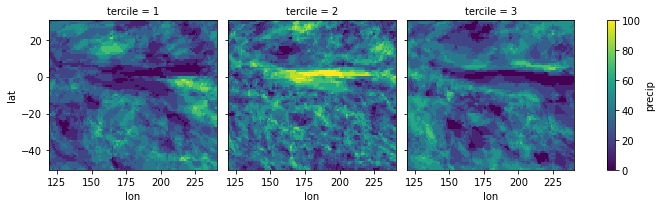

In [37]:
terciles_category_percent.isel(time=0, step=0)[varname_out].plot(col=quantile)

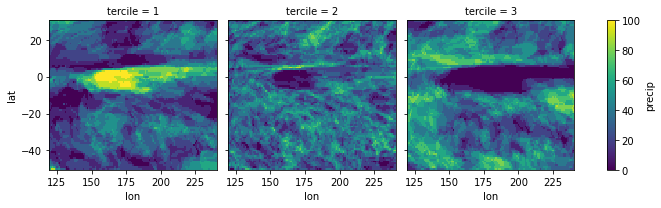

In [38]:
terciles_category_percent.isel(time=-1, step=0)[varname_out].plot(col=quantile)

### most likely category 

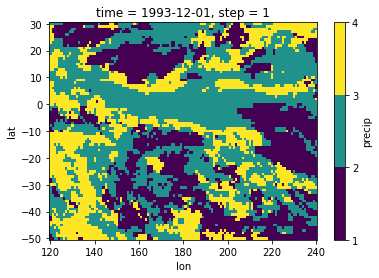

In [39]:
terciles_category_percent.idxmax(dim=quantile)[varname_out].isel(time=0, step=0).plot(levels=[1,2,3,4])

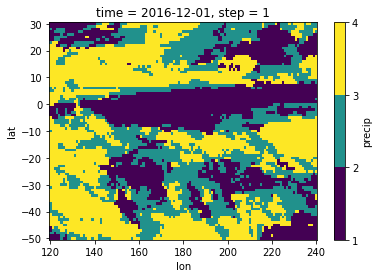

In [40]:
terciles_category_percent.idxmax(dim=quantile)[varname_out].isel(time=-1, step=0).plot(levels=[1,2,3,4])

In [41]:
GCM

'JMA'

In [42]:
period 

'monthly'

In [43]:
quantile

'tercile'

### now saves the tercile probabilities for each year, for the corresponding month 

In [44]:
opath_probs = gcm_path.joinpath(f"{GCM}/{quantile}_probs/{varname.upper()}")

In [45]:
if not opath_probs.exists(): 
    opath_probs.mkdir(parents=True)

In [46]:
for date in terciles_category_percent.time.to_index(): 
    sub = terciles_category_percent.sel(time=date)
    sub = sub.expand_dims({'time':[date]})
    sub.to_netcdf(opath_probs.joinpath(f"{GCM}_{period}_{quantile}s_probs_{date:%Y-%m}.netcdf"))